# Electron Diffraction Individual Analysis

Use this template to carry out the analysis tasks for the Electron Diffraction experiment.  You may need to consult the documentation for different Python packages.  Also recommended: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

## First, import some packages

This is a good idea at the beginning of your notebook to include the packages that you will need.  We will use the four shown below here.  A brief description:
* `numpy` is the foundational package for Python numerical work. It extends and speeds up array operations beyond standard Python, and it includes almost all math functions that you would need for example `sqrt()` (square root) or `cos()` (cosine).  These would be written in code as `np.sqrt()` or `np.cos()`.
* `scipy` is a huge collection of scientific data analysis functions, routines, physicical constants, etc.  This is the second most used package for scientific work.  In this notebook, we will only make use of one physical constant (the speed of light).  Documentation is at [SciPy.org](https://docs.scipy.org/doc/scipy/reference/) with the constants subpackage at https://docs.scipy.org/doc/scipy/reference/constants.html.
* `uncertainties` is a very useful small package that simplifies uncertainty propagation and printing out of quantities with uncertainty.  As part of this notebook, you will calculate an uncertainty the "hard way" by explicit calculation and by using the Uncertainties package. Documentation is at https://pythonhosted.org/uncertainties/
* `matplotlib` is *the* standard plotting package for scientific Python.  We will use a subset called `pyplot` which is modeled after the plotting functions used in MATLAB. The last line below, `%matplotlib inline`, simply forces the plots to appear within the notebook.
* `pandas` is a large data science package.  It's main feature is a set of methods to create and manipulate "Dataframes", which is an enlargement of the idea of an array.  I playe well with NumPy and other packages.  We will use it mainly as a way to read files into data sets in an easy way.

## Graphite data analysis

### Part 1 - Look at your data set

It is always a good idea to make a plot of the raw data before trying to manipulate it.

**Advice:** Enter the measurements you obtained from analyzing the diffraction images int a simple spreadsheet, with the first column being the accelerating voltage and the other columns being the ring/spot diameters.  Save the file as a '.csv'.  

Then use the **Pandas** function `read_csv()` to pull the file into a Pandas Dataframe, like this:

```
gr_data = pd.read_csv('graphite_data.csv')
```

If the last line in the cell is the name of the dataframe, it will print a nice table.

You may obtain the arrays for each column by using the column label, e.g., `gr_data['Voltage (kV)']` is the array of the first column.

In [42]:
import numpy as np
import scipy.constants as const
import uncertainties as unc
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

gr_data = pd.read_csv('graphite_data.csv')
gr_data

,AnodeV (kV),RAve_{10} (mm),StDev_{10} (mm),RAve_{11} (mm),StDev_{11} (mm)
0,4.432,14.851,0.475,25.725667,0.770
1,4.904,14.067,0.465,24.927333,0.416
2,5.382,13.341,0.497,23.309000,1.652
3,5.852,12.963,0.250,22.055333,0.315
4,6.323,12.448,0.473,21.480167,0.174
5,6.808,12.075,0.483,20.612167,0.284
6,7.295,11.442,0.121,19.692167,0.086
7,7.830,11.104,0.255,19.032167,0.333
8,8.314,10.905,0.457,18.386500,0.566
9,8.798,10.458,0.256,18.216667,0.207


#### Plot the data

Below, I'll show how, using the labels I chose for my own data file.  Study the commands, change them, and see what happens.  Hint: study the sections in the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) on Matplotlib. 

After you make the plot, look to make sure your data set does not have any weird points. This is a good way to catch bad data points.

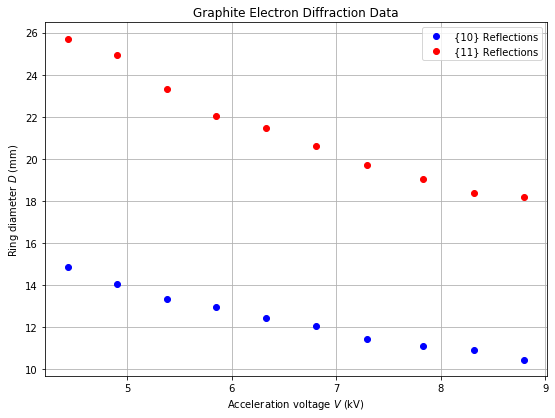

In [43]:
plt.figure(figsize=(9,6.5))
plt.grid()
plt.title('Graphite Electron Diffraction Data')
plt.ylabel(r'Ring diameter $D$ (mm)')
plt.xlabel(r'Acceleration voltage $V$ (kV)')
plt.plot(gr_data['AnodeV (kV)'],gr_data['RAve_{10} (mm)'],'ob',label='{10} Reflections')
plt.plot(gr_data['AnodeV (kV)'],gr_data['RAve_{11} (mm)'],'or',label='{11} Reflections')
plt.legend();

### Part 2 - Transform (linearize) the data 

#### Find $\sin\theta$

First, you need to change the diameter measurements $D$ into $\sin\theta$.  Consider the geometry of the scattering and the fact that you are measuring a diameter. (It is easy to be off by factors of 2.) You will also need the distance $L$ between the target and the screen. Be careful of units! 

Create new arrays that contain the transformed data.  

In [44]:
# SIN(THETA) data
L = 18.06 * 10
sin_data = pd.DataFrame(data = {'Voltage': gr_data['AnodeV (kV)'], 
                                'Sin(Theta) One':np.sin(.5 * np.arctan(gr_data['RAve_{10} (mm)']/L)),
                                'Sin(Theta) Two':np.sin(.5 * np.arctan(gr_data['RAve_{11} (mm)']/L))})
sin_data

,Voltage,Sin(Theta) One,Sin(Theta) Two
0,4.432,0.041012,0.070688
1,4.904,0.038857,0.068525
2,5.382,0.036860,0.064133
3,5.852,0.035820,0.060723
4,6.323,0.034402,0.059156
5,6.808,0.033374,0.056789
6,7.295,0.031630,0.054278
7,7.830,0.030698,0.052474
8,8.314,0.030150,0.050707
9,8.798,0.028917,0.050243


#### Find a function of $V$...

... that linearizes the data relationship:

Combine the DeBroglie relationship, the momentum-energy relationship and the energy-voltage relationship to create a function that predicts $\sin\theta$ as a function of $V$.  Then recast $V$ in order to get a new array that when plotted against $\sin\theta$ should produce a straight line.  The slope of the line should be something you can compare against a predicted value.

In [45]:
# PREDICTED VALUE lambda(V)
# can be simp to Lambda (nm) = sqrt(150/V) * 1000
mc_2 = .511  # (keV)
hc = 1.240           # (eV*nm)
e = 1.602 * 10 **-19      # (C)

wavelengths_Predicted =  pd.DataFrame(data = {'Voltage kV': gr_data['AnodeV (kV)'],'Wavelength NM': 10 * hc/(np.sqrt(2*mc_2*(gr_data['AnodeV (kV)']*1000)))})
wavelengths_Predicted

,Voltage kV,Wavelength NM
0,4.432,0.184245
1,4.904,0.175154
2,5.382,0.167195
3,5.852,0.160341
4,6.323,0.154253
5,6.808,0.148657
6,7.295,0.143610
7,7.830,0.138617
8,8.314,0.134521
9,8.798,0.130769


In [46]:
# Tested Value 
a = 2.46 
scattering = [1,np.sqrt(3)]
wavelengths_Tested = pd.DataFrame(data = {'Voltage kV': gr_data['AnodeV (kV)'],
                                          'Wavelength {10} NM':(np.sqrt(3)*a* sin_data['Sin(Theta) One'])/scattering[0],
                                          'Wavelength {11} NM':(np.sqrt(3)*a* sin_data['Sin(Theta) Two'])/scattering[1]})
wavelengths_Tested

,Voltage kV,Wavelength {10} NM,Wavelength {11} NM
0,4.432,0.174745,0.173892
1,4.904,0.165563,0.168573
2,5.382,0.157054,0.157768
3,5.852,0.152622,0.149379
4,6.323,0.146580,0.145524
5,6.808,0.142203,0.139702
6,7.295,0.134771,0.133523
7,7.830,0.130802,0.129085
8,8.314,0.128464,0.124740
9,8.798,0.123212,0.123597


#### Plot the transformed data

Check your calculation: make a reasonably big plot that shows the "linearized" data set.  If you succeded, it should look like a line.

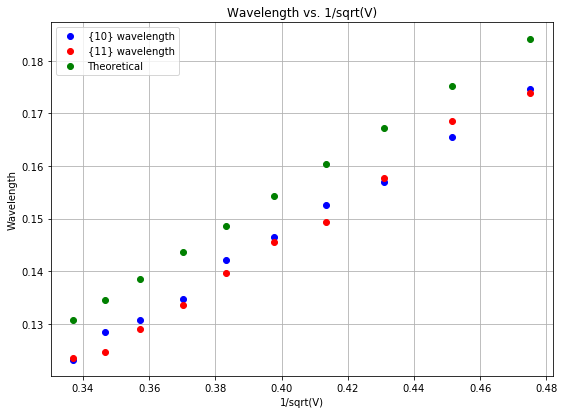

In [47]:
adj_volt = pd.DataFrame(data = {'adj_voltage': 1/np.sqrt(gr_data['AnodeV (kV)'])})
plt.figure(figsize=(9,6.5))
plt.grid()
plt.title('Wavelength vs. 1/sqrt(V)')
plt.ylabel(r'Wavelength')
plt.xlabel(r'1/sqrt(V)')
plt.plot(adj_volt, wavelengths_Tested['Wavelength {10} NM'],'ob',label='{10} wavelength')
plt.plot(adj_volt, wavelengths_Tested['Wavelength {11} NM'],'or',label='{11} wavelength')
plt.plot(adj_volt, wavelengths_Predicted['Wavelength NM'],'og',label='Theoretical')
plt.legend();

### Part 3 - Fit the linearized data

To fit the data set to a line, make use of the **lmfit** package. It is a useful add-on to the SciPy fitting functions.  This package simplifies fitting data to a variety of standard functions.  See the [Lmfit Documentation](https://lmfit.github.io/lmfit-py/index.html) for a full discussion.  The package is quite powerful, but for basic fitting with common functions, it is very easy to use.  

#### Example: Fitting a line

The example below shows how to use the package to fit data to a line, obtain the fit parameters along with uncertainties, and then plot the data and fit. Execute the cell and study how it works.
(Note: the data come from a calibration problem in physics 331)


In [48]:
from lmfit.models import LinearModel
line = LinearModel()

param_guess1 = line.guess(wavelengths_Predicted['Wavelength NM'], x = adj_volt['adj_voltage'])
line_fit1 = line.fit(wavelengths_Predicted['Wavelength NM'], param_guess1, x = adj_volt['adj_voltage'])
#print(line_fit1.fit_report())

param_guess2 = line.guess(wavelengths_Tested['Wavelength {10} NM'], x = adj_volt['adj_voltage'])
line_fit2 = line.fit(wavelengths_Tested['Wavelength {10} NM'], param_guess2, x = adj_volt['adj_voltage'])
#print(line_fit2.fit_report())

param_guess3 = line.guess(wavelengths_Tested['Wavelength {11} NM'], x = adj_volt['adj_voltage'])
line_fit3 = line.fit(wavelengths_Tested['Wavelength {11} NM'], param_guess3, x= adj_volt['adj_voltage'])
#print(line_fit3.fit_report())

print('\nSlope = ',line_fit1.params['slope'].value,'+/-',line_fit1.params['slope'].stderr)
print('\nSlope = ',line_fit2.params['slope'].value,'+/-',line_fit2.params['slope'].stderr)
print('\nSlope = ',line_fit3.params['slope'].value,'+/-',line_fit3.params['slope'].stderr)
#line_fit1.plot();
#line_fit2.plot();
#line_fit3.plot();




Slope =  0.3878789731957094 +/- None

Slope =  0.36674521266920446 +/- 0.007219701026742559

Slope =  0.3856861379721039 +/- 0.010514646208952283


### Fit the line to your data

Repeat the above calculation by feeding in the appropriate arrays from your linearization transformations.  Obtain the slope.  What are the units??

Note: you only need to redo the following instructions, replacing the `wavelength` and `position` arrays:

```
param_guess = line.guess(wavelength, x=position)

line_fit = line.fit(wavelength, param_guess, x=position)

print(line_fit.fit_report())
```

Run the fit for both the inner ring data ({10} refections) and the next ring data ({11} reflections). You should have two different slopes that can be reduced to give the lattice constant. 

In [49]:
fit_x_values1 = np.linspace(0,np.max(adj_volt['adj_voltage']),20)
line_fit1 = line_fit1.eval(line_fit1.params,x = fit_x_values1)
fit_x_values2 = np.linspace(0,np.max(adj_volt['adj_voltage']),20)
line_fit2 = line_fit2.eval(line_fit2.params,x = fit_x_values2)
fit_x_values3 = np.linspace(0,np.max(adj_volt['adj_voltage']),20)
line_fit3 = line_fit3.eval(line_fit3.params,x = fit_x_values3)

### Plot the linefits against the data

Use the `eval()` method to obtain a fitline, for example,

```
fit_x_values = np.linspace(0,np.max(inv_V),20)
fitline_10 = line_fit_10.eval(line_fit_10.params,x=fit_x_values)
```

Then plot the line(s) on your data plot made above.

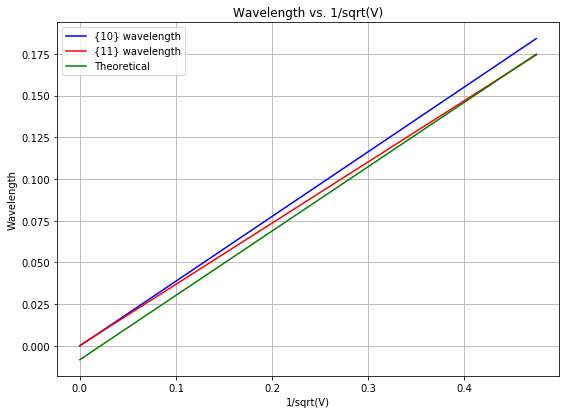

In [50]:
plt.figure(figsize=(9,6.5))
plt.grid()
plt.title('Wavelength vs. 1/sqrt(V)')
plt.ylabel(r'Wavelength')
plt.xlabel(r'1/sqrt(V)')
plt.plot(fit_x_values1, line_fit1,'-b',label='{10} wavelength')
plt.plot(fit_x_values2, line_fit2,'-r',label='{11} wavelength')
plt.plot(fit_x_values3, line_fit3,'-g',label='Theoretical')
plt.legend();

### Part 4 - Evaluate the fit constants

The fit constants (slope) should be related to the physical constants in the DeBroglie relation and electron momentum-energy relation, along with the graphite lattice constant $a$.  Use the SciPy constants (or other Python libraries of cosntants) to calculate the expected value of the slope(s). Compare to the measured one(s) by calculating the lattice constant from the fit(s).

Then from your own measurements and the known value of $a$ (2.46 angstrom), calculate a conversion constant that will allow you to find the wavelength $\lambda$ as a function of the voltage $V$, i.e., a function $\lambda(V)$.  (Note `lambda` is a reserved word in Python; you cannot use it as a variable or function name.)

In [51]:
conversion_constants = pd.DataFrame(data = {'Theoretical': [(.3878789731957094**2)*1000],
                                            'Tested {01}': [(.36674521266920446**2)*1000],
                                            'Tested {11}': [(.3856861379721039**2)*1000]})
conversion_constants

,Theoretical,Tested {01},Tested {11}
0,150.450098,134.502051,148.753797


In [52]:
from lmfit.models import LinearModel
line = LinearModel()
sins = sin_data.values.tolist()
for j in sins: 
    del j[0]
sins = np.array(sins).T
param_guess1 = line.guess(wavelengths_Predicted['Wavelength NM'], x = sins[0])
line_fit1 = line.fit(wavelengths_Predicted['Wavelength NM'], param_guess1, x = sins[0])
param_guess2 = line.guess(wavelengths_Predicted['Wavelength NM'], x = sins[1])
line_fit2 = line.fit(wavelengths_Predicted['Wavelength NM'], param_guess2, x = sins[1])
print('\nSlope = ',line_fit1.params['slope'].value,'+/-',line_fit1.params['slope'].stderr)
print('\nSlope = ',line_fit2.params['slope'].value,'+/-',line_fit2.params['slope'].stderr)

lattice_constants = pd.DataFrame(data = {'theoretical':[2.460],'{10} lattice constant': [4.492448896341586/np.sqrt(3)],'{11} lattice constant': [2.4593635176619273]})
lattice_constants


Slope =  4.492448896341586 +/- 0.08843863388649688

Slope =  2.4593635176619273 +/- 0.0670476384900546


,theoretical,{10} lattice constant,{11} lattice constant
0,2.46,2.593717,2.459364


## Aluminum data analysis

### Part 1 - Look at your data set

As above, first import your data and plot it to make sure it is OK.



In [53]:
al_data = pd.read_csv('aluminum_data.csv')
al_data

,AnodeV (kV),R1,R2,R3,R4,R5
0,4.750,12.828,14.808,21.140,23.826,33.401667
1,5.847,11.675,13.487,18.965,21.360,30.187833
2,6.770,10.780,12.740,17.944,19.922,27.908333
3,7.828,10.056,11.757,16.637,18.447,26.033167
4,8.785,9.646,11.128,15.620,17.519,24.523000


#### Plot some of it
Plot a few ring diameters as a function of voltage.  The data should resemble what you got with graphite.

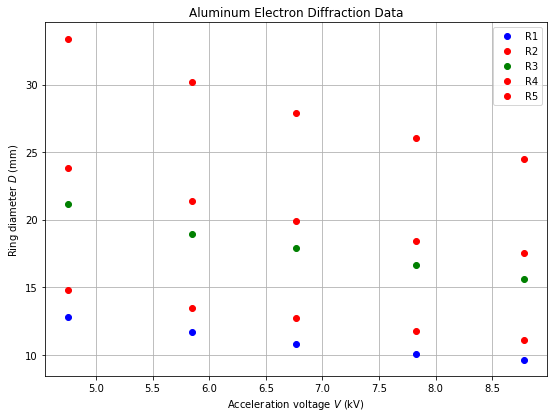

In [54]:
plt.figure(figsize=(9,6.5)) 
plt.grid()
plt.title('Aluminum Electron Diffraction Data')
plt.ylabel(r'Ring diameter $D$ (mm)')
plt.xlabel(r'Acceleration voltage $V$ (kV)')
plt.plot(al_data['AnodeV (kV)'],al_data['R1'],'ob',label='R1')
plt.plot(al_data['AnodeV (kV)'],al_data['R2'],'or',label='R2')
plt.plot(al_data['AnodeV (kV)'],al_data['R3'],'og',label='R3')
plt.plot(al_data['AnodeV (kV)'],al_data['R4'],'or',label='R4')
plt.plot(al_data['AnodeV (kV)'],al_data['R5'],'or',label='R5')
plt.legend();

### Part 2 - Convert $D$ to $\sin\theta$

Repeat what you did with graphite to get the data into the $\sin\theta$ form.  Do this for all voltages.  You should have 5 separate $\sin\theta$ arrays.

In [55]:
# SIN(THETA) data
L = 18.06 * 10 #cm->mm
sin_data = pd.DataFrame(data = {'Voltage': al_data['AnodeV (kV)'], 
                                'Sin(Theta) One':np.sin(.5 * np.arctan(al_data['R1']/L)),
                                'Sin(Theta) Two':np.sin(.5 * np.arctan(al_data['R2']/L)),
                                'Sin(Theta) Three':np.sin(.5 * np.arctan(al_data['R3']/L)),
                                'Sin(Theta) Four':np.sin(.5 * np.arctan(al_data['R4']/L)),
                                'Sin(Theta) Five':np.sin(.5 * np.arctan(al_data['R5']/L))})
sin_data

,Voltage,Sin(Theta) One,Sin(Theta) Two,Sin(Theta) Three,Sin(Theta) Four,Sin(Theta) Five
0,4.750,0.035448,0.040894,0.058229,0.065538,0.091314
1,5.847,0.032272,0.037262,0.052290,0.058829,0.082716
2,6.770,0.029805,0.035206,0.049496,0.054905,0.076584
3,7.828,0.027808,0.032498,0.045915,0.050873,0.071520
4,8.785,0.026677,0.030765,0.043124,0.048332,0.067429


In [56]:
# PREDICTED VALUE 
# can be simp to Lambda (nm) = sqrt(150/V) * 1000
#mind kV to V
mc_2 = .511  # (keV)
hc = 1.240           # (eV*nm)
e = 1.602 * 10 **-19      # (C)

wavelengths_Predicted =  pd.DataFrame(data = {'Voltage kV': al_data['AnodeV (kV)'],'Wavelength NM': 10 * hc/(np.sqrt(2*mc_2*(al_data['AnodeV (kV)']*1000)))})
wavelengths_Predicted

,Voltage kV,Wavelength NM
0,4.750,0.177971
1,5.847,0.160409
2,6.770,0.149074
3,7.828,0.138634
4,8.785,0.130866


### Part 3 - Calculate Ring Spacing for Different Structures

The ring spacings (and $\sin\theta$) should be proportional to $\sqrt{h^2+k^2+l^2}$ for the appropriate collection of $h,k,l$ integers.  For the cubic structures there are three possibilities: simple cubic, which allows all values of $h,k,l$, body-centered cubic which requires the sum $h+k+l$ to be even, and face-centered cubic which requires $h,k,l$ to be all even or all odd (another way to say this is that the sum of any two is even).

Either work out the possibilities for the first 6 rings for the three different possible structures by hand, or write some code to do this.  Then create arrays `x_sc`, `x_bcc`, and `x_fcc` which will allow you to plot the ring diameters versus each array.  From this, determine which one gives the best straight line.

**NOTE** For ring 5 (usually the outermost), you will find that it does not match the 5th allowed reflection.  Try a higher one in the series. (Which works best?)

In [57]:
sc =  [np.sqrt(1), np.sqrt(2),np.sqrt(3),np.sqrt(4),  np.sqrt(9) ]
bcc = [np.sqrt(2), np.sqrt(4),np.sqrt(6),np.sqrt(8),  np.sqrt(16)]
fcc = [np.sqrt(3), np.sqrt(4),np.sqrt(8),np.sqrt(11), np.sqrt(19)]


### Now plot data against $hkl$

Make a plot with one of the ring-diameter sets versus the spacings for the three different x-value sets.  Find the match that looks most linear.

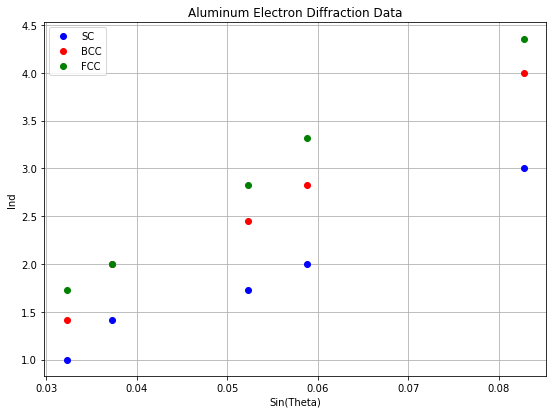

In [58]:
plt.figure(figsize=(9,6.5)) 
plt.grid()

#new arrays for intermediate testing
sins1 = [0.027808, 0.032498, 0.045915, 0.050873, 0.071520]
sins2 = [0.032272, 0.037262, 0.052290, 0.058829, 0.082716]

plt.title('Aluminum Electron Diffraction Data')
plt.ylabel(r'Ind')
plt.xlabel(r'Sin(Theta)')
plt.plot(sins2,sc ,'ob',label='SC')
plt.plot(sins2,bcc,'or',label='BCC')
plt.plot(sins2,fcc,'og',label='FCC')
plt.legend();


### Part 4 - Fit to the best structure

Fit a line to the $hkl$ group that has the closest match to the ring spacing.  The slope should give you $\frac{\lambda}{2a}$ for that voltage.  As a quick check, calculate the lattice constant; it should be about 4 aangstrom.


Slope =  52.7617140416583 +/- 2.461202785134366
a =  4.231736237646669


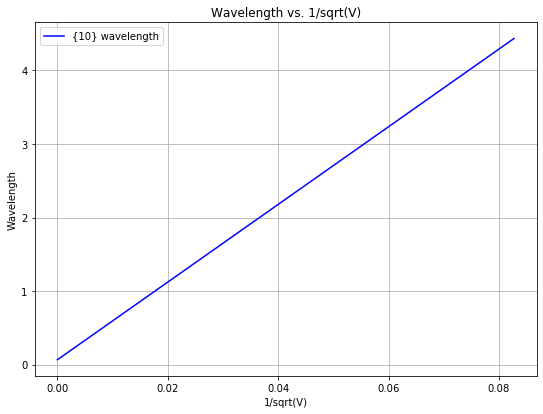

In [59]:
from lmfit.models import LinearModel
line = LinearModel()
param_guess = line.guess(fcc, x = sins2)
line_fit = line.fit(fcc, param_guess, x = sins2)
#print(line_fit1.fit_report())

print('\nSlope = ',line_fit.params['slope'].value,'+/-',line_fit.params['slope'].stderr)
fit_x_values = np.linspace(0,np.max(sins2),20)
line_fit = line_fit.eval(line_fit.params,x = fit_x_values)

plt.figure(figsize=(9,6.5))
plt.grid()
plt.title('Wavelength vs. 1/sqrt(V)')
plt.ylabel(r'Wavelength')
plt.xlabel(r'1/sqrt(V)')
plt.plot(fit_x_values, line_fit,'-b',label='{10} wavelength')
plt.legend();
a_7828 = .5 * wavelengths_Predicted.loc[1,'Wavelength NM'] * 52.7617140416583
print('a = ', a_7828)

### Part 5 - Repeat the process for the other voltages

Fit the $\sin\theta$ versus $hkl$ lengths for the other data sets in the aluminum measurements.  Obtain the slopes (all proportional to $\lambda/2a$ for each voltage).  Then combine these results to plot $\lambda/2a$ versus $\lambda(V)$.  The slope of this line should give you the best value of the aluminum lattice constant $a$.

You do not need to plot the intermediate fits (but examine the statistics to make sure you have not made a mistake).  Do plot the final fit.

OPTIONAL: Calculate the uncertainty in $a$ from the final plot/fit result.

### Fits here for $\lambda/2a$ values for each voltage


In [60]:
line = LinearModel()

wl_List = wavelengths_Predicted.values.tolist()
sins = [[0.035448, 0.040894, 0.058229, 0.065538, 0.091314],
        [0.032272, 0.037262, 0.052290, 0.058829, 0.082716],
        [0.029805, 0.035206, 0.049496, 0.054905, 0.076584],
        [0.027808, 0.032498, 0.045915, 0.050873, 0.071520],
        [0.026677, 0.030765, 0.043124, 0.048332, 0.067429]]

param_guess1 = line.guess(fcc, x = sins[0])
line_fit1 = line.fit(fcc, param_guess1, x = sins[0])
param_guess2 = line.guess(fcc, x = sins[1])
line_fit2 = line.fit(fcc, param_guess2, x = sins[1])
param_guess3 = line.guess(fcc, x = sins[2])
line_fit3 = line.fit(fcc, param_guess3, x = sins[2])
param_guess4 = line.guess(fcc, x = sins[3])
line_fit4 = line.fit(fcc, param_guess4, x = sins[3])
param_guess5 = line.guess(fcc, x = sins[4])
line_fit5 = line.fit(fcc, param_guess5, x = sins[4])


print('\nSlope = ',line_fit1.params['slope'].value,'+/-',line_fit1.params['slope'].stderr)
print('\nSlope = ',line_fit2.params['slope'].value,'+/-',line_fit2.params['slope'].stderr)
print('\nSlope = ',line_fit3.params['slope'].value,'+/-',line_fit3.params['slope'].stderr)
print('\nSlope = ',line_fit4.params['slope'].value,'+/-',line_fit4.params['slope'].stderr)
print('\nSlope = ',line_fit5.params['slope'].value,'+/-',line_fit5.params['slope'].stderr)


Slope =  47.54055291018409 +/- 1.863518833111981

Slope =  52.7617140416583 +/- 2.461202785134366

Slope =  57.255065317257774 +/- 2.5755000810431397

Slope =  61.1110461807865 +/- 2.949189427477692

Slope =  65.31958046531886 +/- 2.8658623567615242


### Plot and fit here for final $\lambda/2a$ vs $\lambda(V)$


Slope =  0.11440714205997335 +/- 0.0020982559817610074


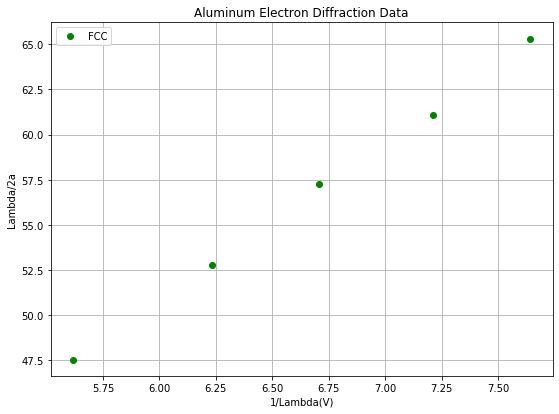

In [91]:
slopes = [47.54055291018409, 52.7617140416583, 57.255065317257774, 61.1110461807865, 65.31958046531886]
param_guess = line.guess(1/wavelengths_Predicted['Wavelength NM'], x = slopes)
line_fit = line.fit(1/wavelengths_Predicted['Wavelength NM'], param_guess, x = slopes)

plt.figure(figsize=(9,6.5)) 
plt.grid()
plt.title('Aluminum Electron Diffraction Data')
plt.ylabel(r'Lambda/2a')
plt.xlabel(r'1/Lambda(V)')
plt.plot(1/wavelengths_Predicted['Wavelength NM'],slopes,'og',label='FCC')
plt.legend();

print('\nSlope = ',line_fit.params['slope'].value,'+/-',line_fit.params['slope'].stderr)

### Calculate and print Al lattice constant (maybe with uncertainty).

In [87]:
a = 1/(2*(0.11440714205997335))
a

4.370356526674664

In [88]:
# unweighted average for comparison 
al_lattice = pd.DataFrame(data= {'Voltage kV':al_data['AnodeV (kV)'],'Slope':slopes ,'lattice constant': .5 * wavelengths_Predicted['Wavelength NM']* slopes})
al_lattice

,Voltage kV,Slope,lattice constant
0,4.750,47.540553,4.230422
1,5.847,52.761714,4.231736
2,6.770,57.255065,4.267621
3,7.828,61.111046,4.236045
4,8.785,65.319580,4.274042
